# Import modules

In [1]:
import os
import numpy as np
import scanpy as sc
import anndata
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

In [2]:
import session_info
session_info.show()

In [3]:
import importlib.util
import sys

spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/tissueaxis.py")
tissueaxis = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = tissueaxis
spec.loader.exec_module(tissueaxis)

In [4]:
sc.settings.set_figure_params(dpi=80,dpi_save=300)

In [5]:
figdir = '/nfs/team205/heart/fetal_ms_figures/raw_plots_kk'

# Functions

In [6]:
# This function selects the data for multiple slides from the spatial anndata object.
# Modified `select_slide` in cell2loc for multiple slides

# @param adata: anndata object with multiple spatial experiments
# @param s: list of selected slides
# @param s_col: column in adata.obs listing experiment name for each location

def select_multislide(adata, s, s_col='sample'):

    slides = adata[adata.obs[s_col].isin(s), :]
    s_keys = list(slides.uns['spatial'].keys())
    
    uns_dict = {}
    for ss in s:
        s_spatial=np.array(s_keys)[[ss in k for k in s_keys]][0]
        uns_dict[s_spatial]=slides.uns['spatial'][s_spatial]
    
    slides.uns['spatial'] = uns_dict

    return slides

# Read in adata

In [7]:
adata_ffpe = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-FFPE_foetal_raw.h5ad')
print(adata_ffpe.shape)
adata_oct_healthy = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-OCT_foetal_raw.h5ad')
print(adata_oct_healthy.shape)
adata_oct_healthy_LV = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-OCT-LV_foetal_raw.h5ad')
print(adata_oct_healthy_LV.shape)
adata_oct_t21 = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-OCT-T21_foetal_raw.h5ad')
print(adata_oct_t21.shape)

(19973, 18085)
(14261, 33538)
(6767, 33538)
(11238, 33538)


In [8]:
# concatenate oct adata
adata_oct_healthy.obs['status'] = 'Healthy'
adata_oct_healthy_LV.obs['status'] = 'Healthy'
adata_oct_t21.obs['status'] = 'Trisomy21'

adata_oct = adata_oct_healthy.concatenate(
    [adata_oct_healthy_LV,adata_oct_t21],
    batch_key=None,
    index_unique=None,
    join="inner"
)

adata_oct.obs['status'].value_counts()

Healthy      21028
Trisomy21    11238
Name: status, dtype: int64

In [9]:
# log-normalise
sc.pp.normalize_total(adata_oct, target_sum=1e4)
sc.pp.log1p(adata_oct)

sc.pp.normalize_total(adata_ffpe, target_sum=1e4)
sc.pp.log1p(adata_ffpe)

# reset var_names
adata_oct.var.set_index('SYMBOL',inplace=True)
adata_ffpe.var.set_index('SYMBOL',inplace=True)

In [10]:
# get all celltypes
# only the LV cell types will be appeared since concatenated with LV object
all_celltypes = adata_oct.obsm['q05_cell_abundance_w_sf'].columns
all_celltypes = [x.replace('q05cell_abundance_w_sf_','') for x in all_celltypes]
print(len(all_celltypes))
print(all_celltypes[:5])

41
['VentricularCardiomyocytesLeftCompact', 'VentricularCardiomyocytesLeftTrabeculated', 'VentricularConductionSystemProximal', 'VentricularConductionSystemDistal', 'CoronaryVesselAdventitialFibroblasts']


In [11]:
# subset cell types in ffpe
adata_ffpe.obsm['q05_cell_abundance_w_sf'] = adata_ffpe.obsm['q05_cell_abundance_w_sf'][[f'q05cell_abundance_w_sf_{x}' for x in all_celltypes]]

# modify cell type names
celltype_rename = utils.read_pkl('/nfs/team205/heart/anndata_objects/Foetal/fine_grain_rename_dictionary.pkl')
adata_ffpe.obsm['q05_cell_abundance_w_sf'].columns = [x.replace(x.split('q05cell_abundance_w_sf_')[1],celltype_rename[x.split('q05cell_abundance_w_sf_')[1]]) \
                                                      for x in adata_ffpe.obsm['q05_cell_abundance_w_sf'].columns]
adata_oct.obsm['q05_cell_abundance_w_sf'].columns = [x.replace(x.split('q05cell_abundance_w_sf_')[1],celltype_rename[x.split('q05cell_abundance_w_sf_')[1]]) \
                                                      for x in adata_oct.obsm['q05_cell_abundance_w_sf'].columns]

# Add axis

In [12]:
# add
ffpe_samples = list(set(adata_ffpe.obs['sample']))
oct_samples = list(set(adata_oct.obs['sample']))

adata_oct.obs['transmural_axis'] = np.nan
adata_ffpe.obs['transmural_axis'] = np.nan

axis_files = os.listdir('/nfs/team205/heart/visium_axis/foetal/transmural_LV')
for file in axis_files:
    # read in
    axis = pd.read_csv(f'/nfs/team205/heart/visium_axis/foetal/transmural_LV/{file}',index_col=0)
    # add to anndata
    if file.split('.csv')[0] in oct_samples:
        adata_oct.obs.loc[axis.index,'transmural_axis'] = axis.copy()
    elif file.split('.csv')[0] in ffpe_samples:
        adata_ffpe.obs.loc[axis.index,'transmural_axis'] = axis.copy()

# select spots with axis
# adata_oct = adata_oct[adata_oct.obs['transmural_axis'].isna()==False]
# adata_ffpe = adata_ffpe[adata_ffpe.obs['transmural_axis'].isna()==False]

In [13]:
pd.crosstab(adata_oct.obs['sample'],adata_oct.obs['transmural_axis'].isna()==False)

transmural_axis     False  True 
sample                          
HCAHeartST10298114    812      0
HCAHeartST10298115    991      0
HCAHeartST10298116   1187      0
HCAHeartST10298117   1085      0
HCAHeartST10298120   1108      0
HCAHeartST10317184    672    164
HCAHeartST10317185    601    103
HCAHeartST10317186    619     74
HCAHeartST10317189    944      0
HCAHeartST10317190    609      0
HCAHeartST11605165    591   1837
HCAHeartST11605166   1120      0
HCAHeartST11605167    486    206
HCAHeartST11605168    552     87
HCAHeartST13162329   1623      0
HCAHeartST13162330   1666   1140
HCAHeartST13162331   1236   1102
HCAHeartST13162332    413      0
HCAHeartST13162333   2490      0
HCAHeartST13162334   2675      0
HCAHeartST13162335   2803      0
HCAHeartST13162336   1330   1940

In [14]:
pd.crosstab(adata_ffpe.obs['sample'],adata_ffpe.obs['transmural_axis'].isna()==False)

transmural_axis    False  True 
sample                         
BHF_F_Hea13295830   8701   2410
BHF_F_Hea13295831   6667   2195

In [15]:
pd.crosstab(adata_oct.obs['sample'],adata_oct.obs['cell2loc-map_group'])

cell2loc-map_group  4PCW  5PCW  7PCW  13PCW  20PCW  T21_13PCW
sample                                                       
HCAHeartST10298114     0     0   812      0      0          0
HCAHeartST10298115     0     0   991      0      0          0
HCAHeartST10298116     0     0  1187      0      0          0
HCAHeartST10298117     0     0  1085      0      0          0
HCAHeartST10298120     0     0  1108      0      0          0
HCAHeartST10317184     0     0   836      0      0          0
HCAHeartST10317185     0     0   704      0      0          0
HCAHeartST10317186     0     0   693      0      0          0
HCAHeartST10317189     0     0   944      0      0          0
HCAHeartST10317190     0     0   609      0      0          0
HCAHeartST11605165     0     0     0   2428      0          0
HCAHeartST11605166     0     0     0   1120      0          0
HCAHeartST11605167     0   692     0      0      0          0
HCAHeartST11605168     0   639     0      0      0          0
HCAHeartST13162329     0     0     0      0   1623          0
HCAHeartST13162330     0     0     0      0   2806          0
HCAHeartST13162331     0     0     0      0   2338          0
HCAHeartST13162332   413     0     0      0      0          0
HCAHeartST13162333     0     0     0      0      0       2490
HCAHeartST13162334     0     0     0      0      0       2675
HCAHeartST13162335     0     0     0      0      0       2803
HCAHeartST13162336     0     0     0      0      0       3270

# Plot transmural axis

In [16]:
slide_id = 'BHF_F_Hea13295831'

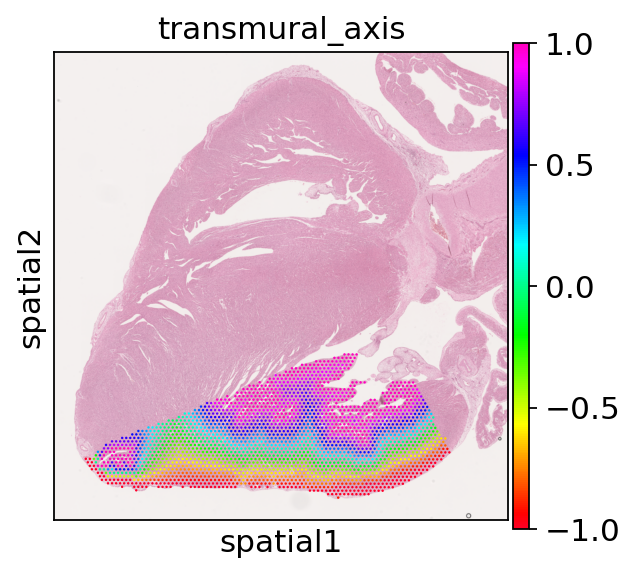

In [17]:
slide = select_multislide(adata_ffpe, [slide_id])
sc.pl.spatial(slide,color=['transmural_axis'],cmap='gist_rainbow',show=False)
plt.savefig(f"{figdir}/visium_tm-axis_{slide_id}.pdf", bbox_inches="tight",dpi=300)

# Concatenate OCT and FFPE object

In [38]:
# select spots with axis
adata_oct = adata_oct[adata_oct.obs['transmural_axis'].isna()==False]
adata_ffpe = adata_ffpe[adata_ffpe.obs['transmural_axis'].isna()==False]
# for later plotting
adata_oct_healthy = adata_oct_healthy[list(set(adata_oct_healthy.obs_names).intersection(adata_oct.obs_names))]
adata_oct_healthy_LV = adata_oct_healthy_LV[list(set(adata_oct_healthy_LV.obs_names).intersection(adata_oct.obs_names))]

In [19]:
# concatenate OCT and FFPE objects
adata_ffpe.obs['cell2loc-map_group'] = '16PCW_FFPE'

adata_all = adata_oct.concatenate(
    adata_ffpe,
    batch_key=None,
    index_unique=None,
    join="inner"
)

In [20]:
pd.crosstab(adata_all.obs['sample'],adata_all.obs['cell2loc-map_group'])

cell2loc-map_group  13PCW  16PCW_FFPE  20PCW  5PCW  7PCW  T21_13PCW
sample                                                             
BHF_F_Hea13295830       0        2410      0     0     0          0
BHF_F_Hea13295831       0        2195      0     0     0          0
HCAHeartST10317184      0           0      0     0   164          0
HCAHeartST10317185      0           0      0     0   103          0
HCAHeartST10317186      0           0      0     0    74          0
HCAHeartST11605165   1837           0      0     0     0          0
HCAHeartST11605167      0           0      0   206     0          0
HCAHeartST11605168      0           0      0    87     0          0
HCAHeartST13162330      0           0   1140     0     0          0
HCAHeartST13162331      0           0   1102     0     0          0
HCAHeartST13162336      0           0      0     0     0       1940

# Plot cells along the axis and time

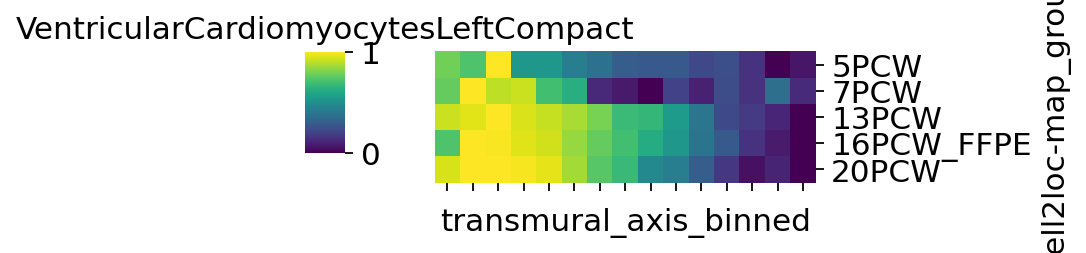

In [22]:
features_to_plot = 'VentricularCardiomyocytesLeftCompact'

tissueaxis.plot_axis_split(adata_all,
                           feature_to_plot=features_to_plot,
                           feature_type='celltype',
                           splitby='cell2loc-map_group',
                           groups_order=[ '5PCW', '7PCW','13PCW', '16PCW_FFPE','20PCW'],
                           figsize=(5, 3.5),
                           cbar_pos=(0, 0.7, 0.05, 0.18),
                           save=f'{figdir}/tm-axis_{features_to_plot}_per-week.pdf'
                          )

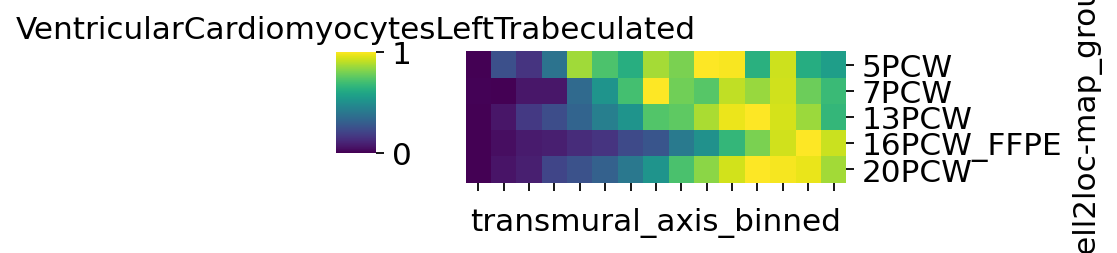

In [23]:
features_to_plot = 'VentricularCardiomyocytesLeftTrabeculated'

tissueaxis.plot_axis_split(adata_all,
                           feature_to_plot=features_to_plot,
                           feature_type='celltype',
                           splitby='cell2loc-map_group',
                           groups_order=[ '5PCW', '7PCW','13PCW', '16PCW_FFPE','20PCW'],
                           figsize=(5, 3.5),
                           cbar_pos=(0, 0.7, 0.05, 0.18),
                           save=f'{figdir}/tm-axis_{features_to_plot}_per-week.pdf'
                          )

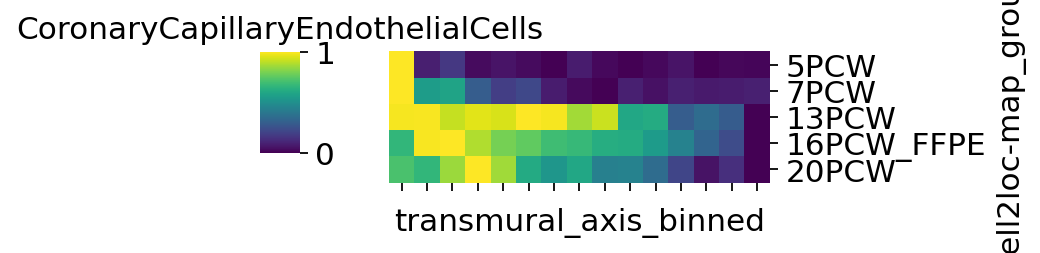

In [24]:
features_to_plot = 'CoronaryCapillaryEndothelialCells'

tissueaxis.plot_axis_split(adata_all,
                           feature_to_plot=features_to_plot,
                           feature_type='celltype',
                           splitby='cell2loc-map_group',
                           groups_order=[ '5PCW', '7PCW','13PCW', '16PCW_FFPE','20PCW'],
                           figsize=(5, 3.5),
                           cbar_pos=(0, 0.7, 0.05, 0.18),
                           save=f'{figdir}/tm-axis_{features_to_plot}_per-week.pdf'
                          )

# Cell type transition along transmural axis

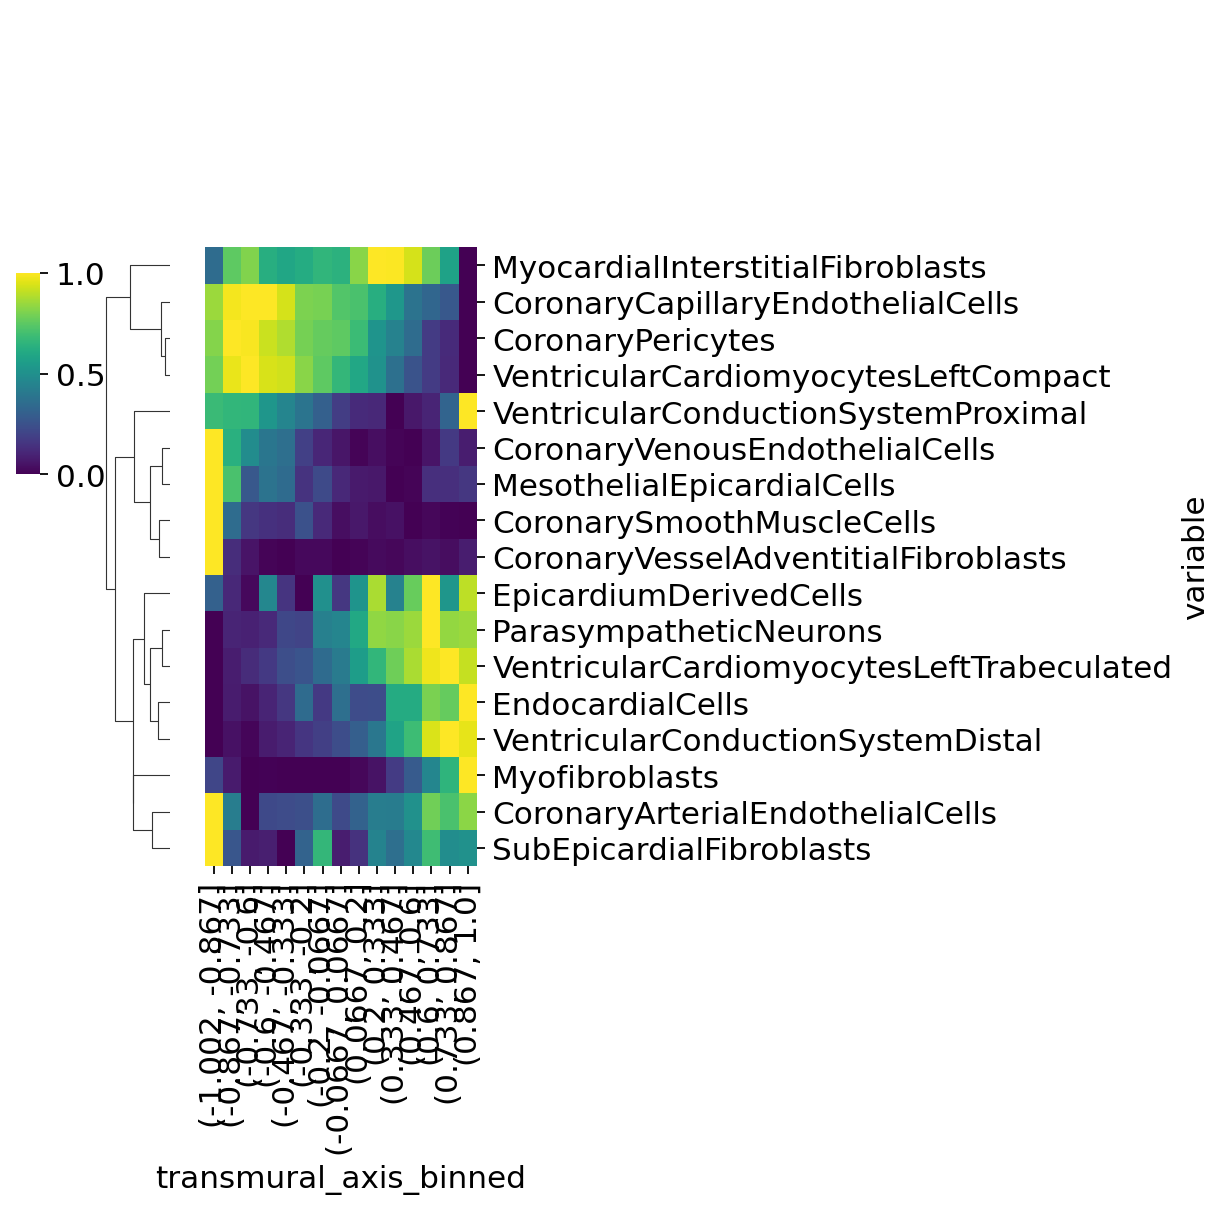

In [58]:
# only euploid
tissueaxis.plot_axis(adata_all[adata_all.obs['status']=='Healthy'],
                     axis_col='transmural_axis',
                     n_bin=15,
                     feature_type='celltype',
                     correlation=False,
                     threshold_cell_abundance=0.1,
                     min_max_scale=True,
                     figsize=(3, 7),
                     save=f'{figdir}/tm-axis_OCT-FFPE_celltypes_thresh-0p1.pdf'
                    )

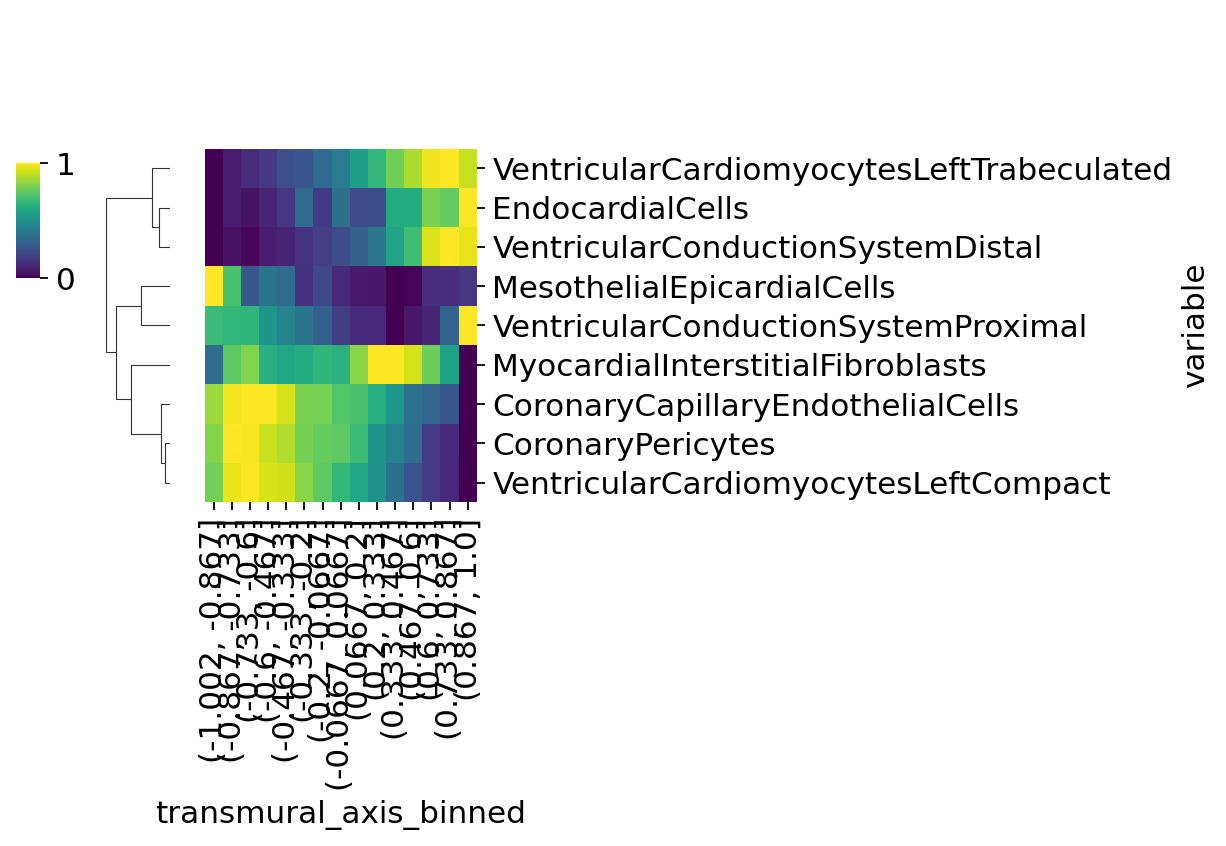

In [56]:
# only euploid
tissueaxis.plot_axis(adata_all[adata_all.obs['status']=='Healthy'],
                     axis_col='transmural_axis',
                     n_bin=15,
                     feature_type='celltype',
                     correlation=False,
                     threshold_cell_abundance=0.4,
                     min_max_scale=True,
                     figsize=(3, 4)
                     # save=f'{figdir}/tm-axis_OCT_celltypes.pdf'
                    )

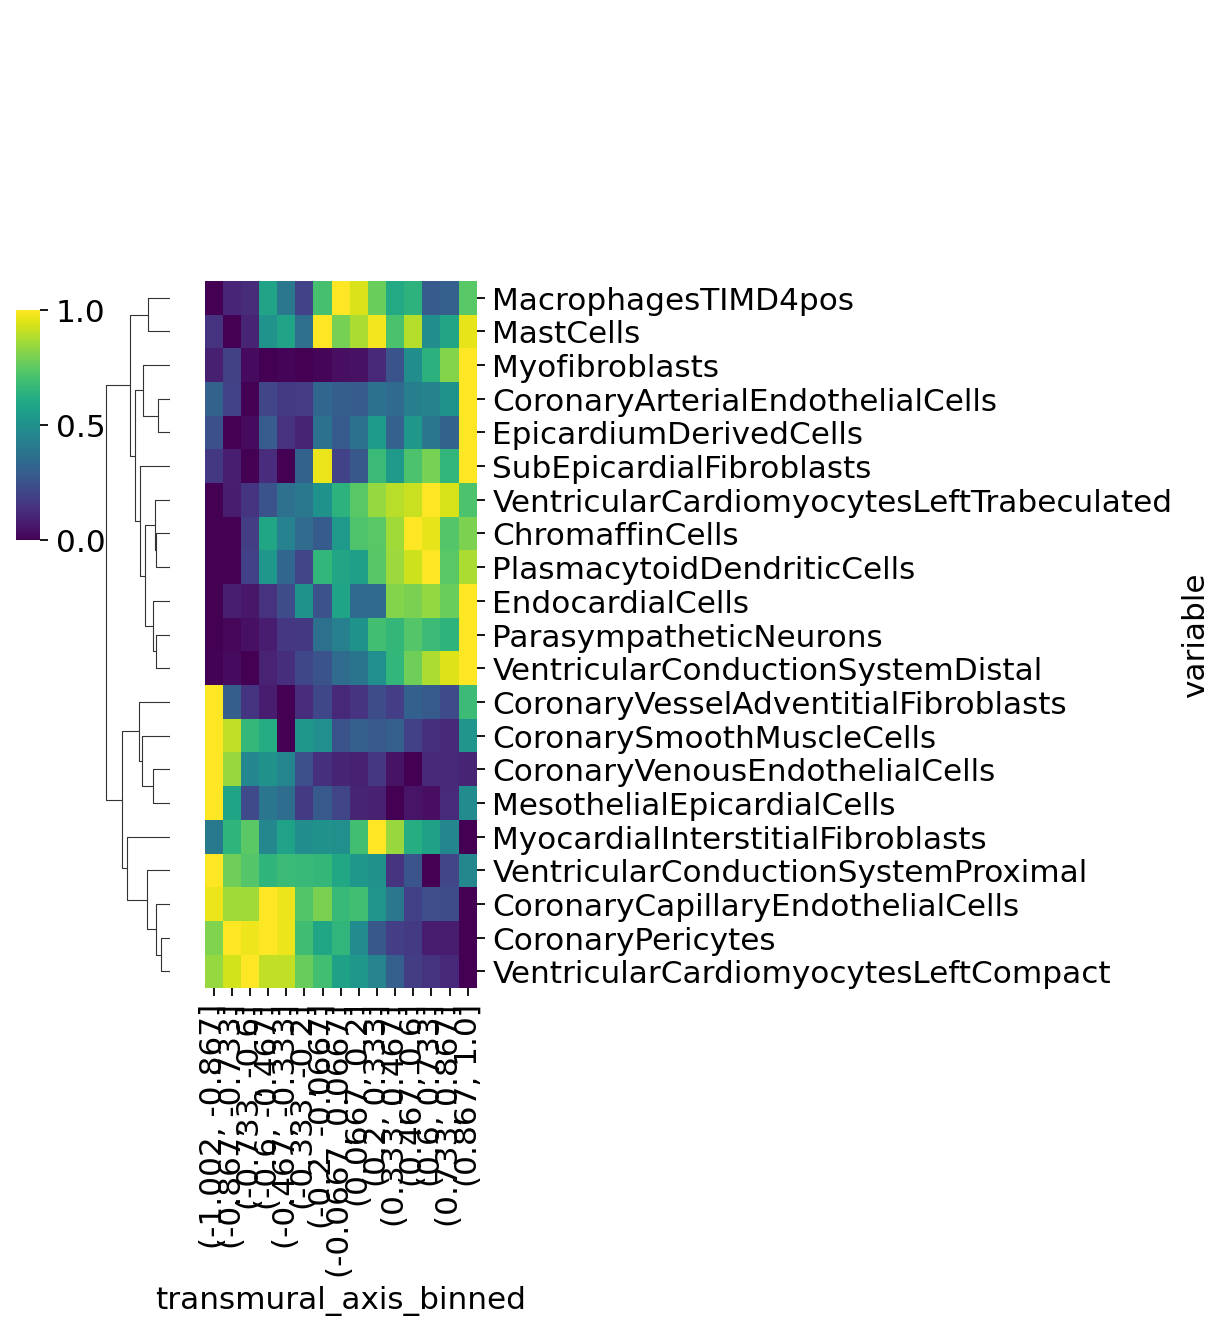

In [21]:
# OCT, cell type transition
# only euploid
tissueaxis.plot_axis(adata_oct[adata_oct.obs['status']=='Healthy'],
                     axis_col='transmural_axis',
                     n_bin=15,
                     feature_type='celltype',
                     correlation=False,
                     threshold_cell_abundance=0.1,
                     # save=f'{figdir}/tm-axis_OCT_celltypes.pdf'
                    )

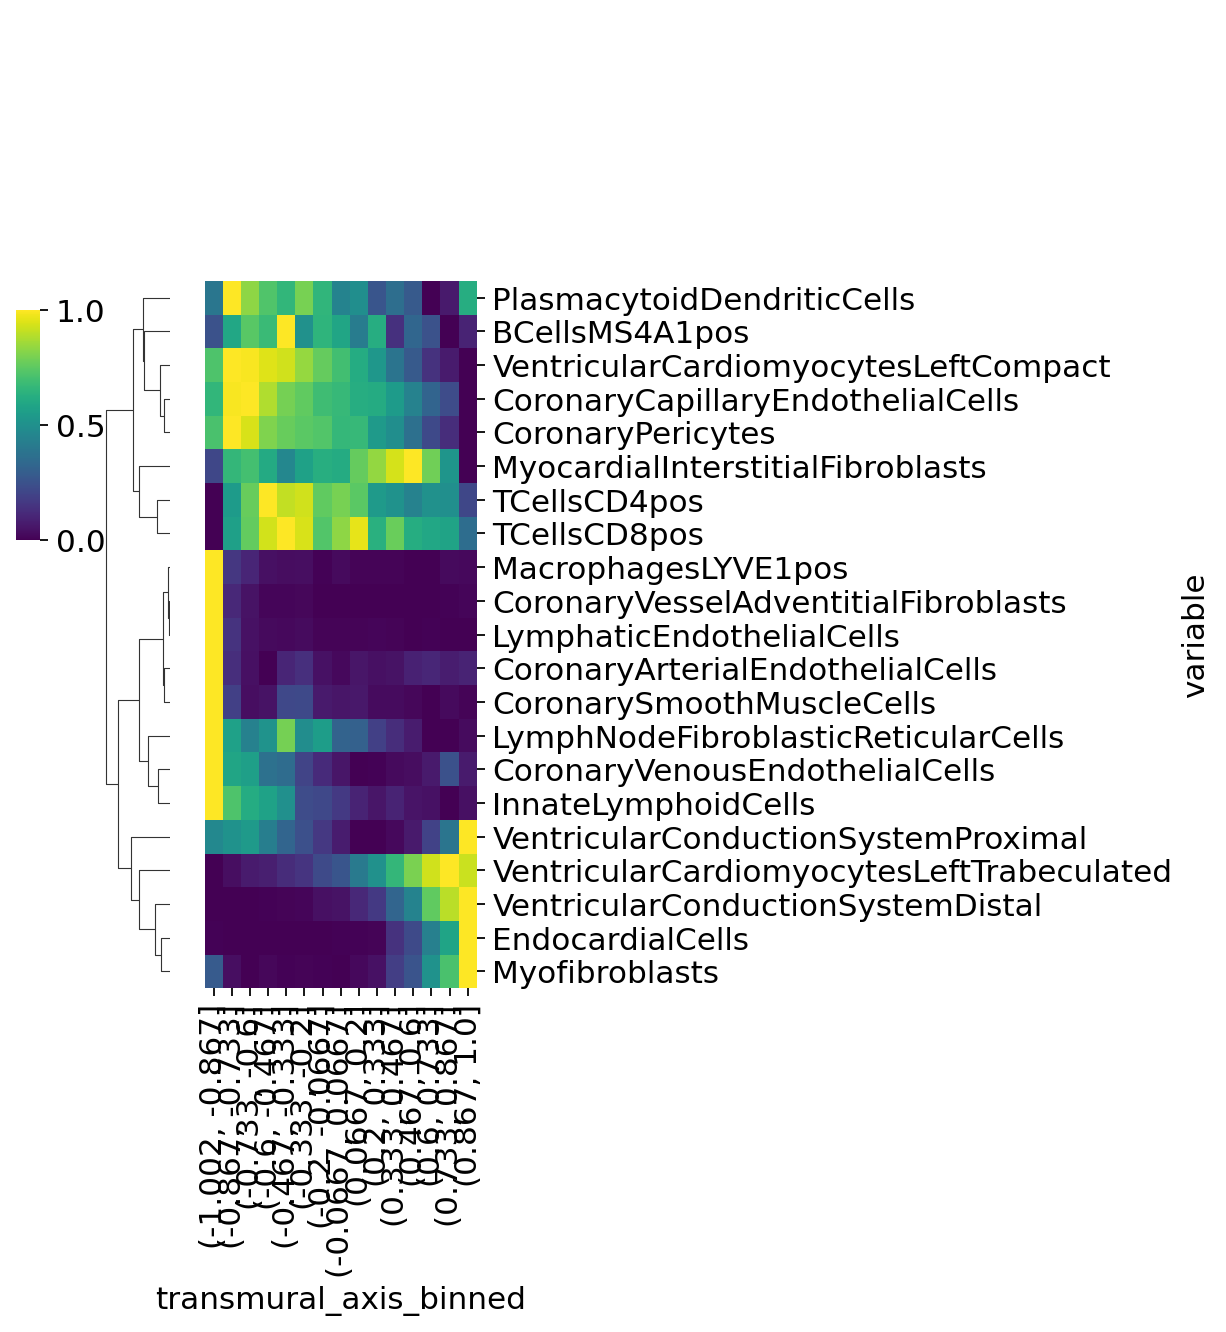

In [36]:
# FFPE, cell type transition
# only euploid
tissueaxis.plot_axis(adata_ffpe[adata_ffpe.obs['status']=='Healthy'],
                     axis_col='transmural_axis',
                     n_bin=15,
                     feature_type='celltype',
                     correlation=False,
                     threshold_cell_abundance=0.03,
                    )

# Plot compact and trabeculated CM for each age

In [34]:
pd.crosstab(adata_oct_healthy.obs['sample'],adata_oct_healthy.obs['cell2loc-map_group'])

cell2loc-map_group  4PCW  5PCW  7PCW  13PCW
sample                                     
HCAHeartST10298114     0     0   812      0
HCAHeartST10298115     0     0   991      0
HCAHeartST10298116     0     0  1187      0
HCAHeartST10298117     0     0  1085      0
HCAHeartST10298120     0     0  1108      0
HCAHeartST10317184     0     0   836      0
HCAHeartST10317185     0     0   704      0
HCAHeartST10317186     0     0   693      0
HCAHeartST10317189     0     0   944      0
HCAHeartST10317190     0     0   609      0
HCAHeartST11605165     0     0     0   2428
HCAHeartST11605166     0     0     0   1120
HCAHeartST11605167     0   692     0      0
HCAHeartST11605168     0   639     0      0
HCAHeartST13162332   413     0     0      0

In [41]:
pd.crosstab(adata_oct_healthy_LV.obs['sample'],adata_oct_healthy_LV.obs['cell2loc-map_group'])

cell2loc-map_group  20PCW
sample                   
HCAHeartST13162330   1140
HCAHeartST13162331   1102

[<Axes: title={'center': 'VentricularCardiomyocytesLeftCompact'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'VentricularCardiomyocytesLeftTrabeculated'}, xlabel='spatial1', ylabel='spatial2'>]

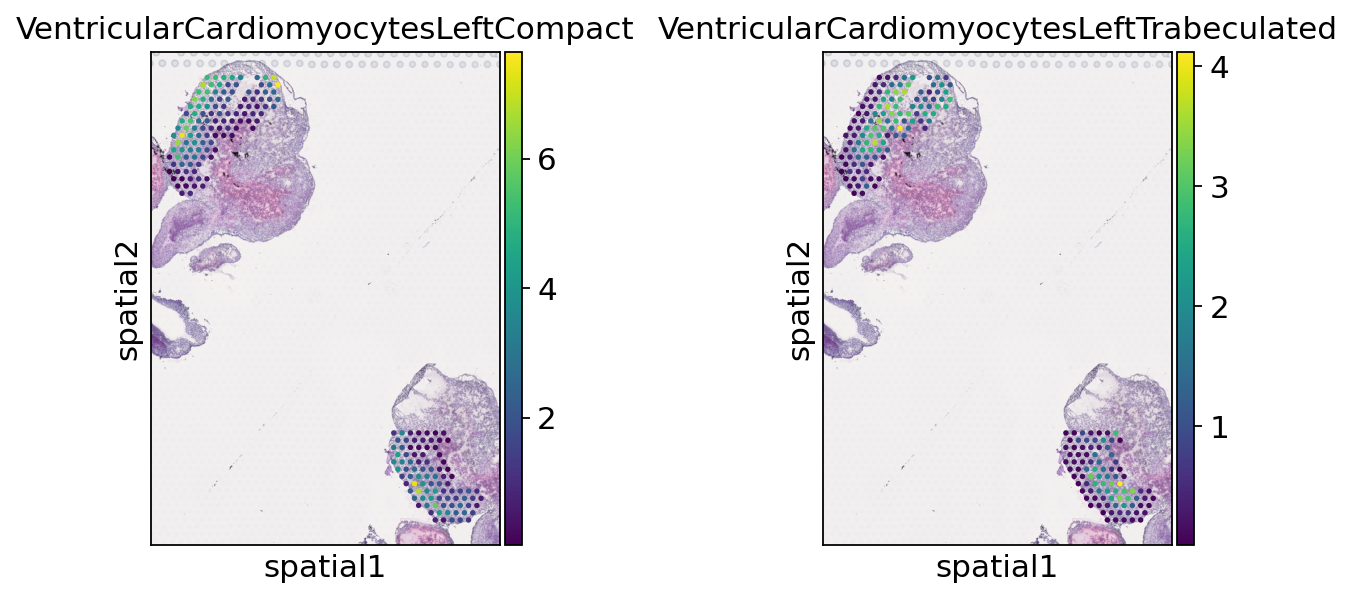

In [45]:
slide_id = 'HCAHeartST11605167'
slide = select_multislide(adata_oct_healthy, [slide_id])
cell2loc_out = slide.obsm['q05_cell_abundance_w_sf'].copy()
cell2loc_out.columns = [x.replace('q05cell_abundance_w_sf_','') for x in cell2loc_out.columns]
slide.obs[cell2loc_out.columns] = cell2loc_out.copy()
sc.pl.spatial(slide,color=['VentricularCardiomyocytesLeftCompact','VentricularCardiomyocytesLeftTrabeculated'],show=False)

[<Axes: title={'center': 'VentricularCardiomyocytesLeftCompact'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'VentricularCardiomyocytesLeftTrabeculated'}, xlabel='spatial1', ylabel='spatial2'>]

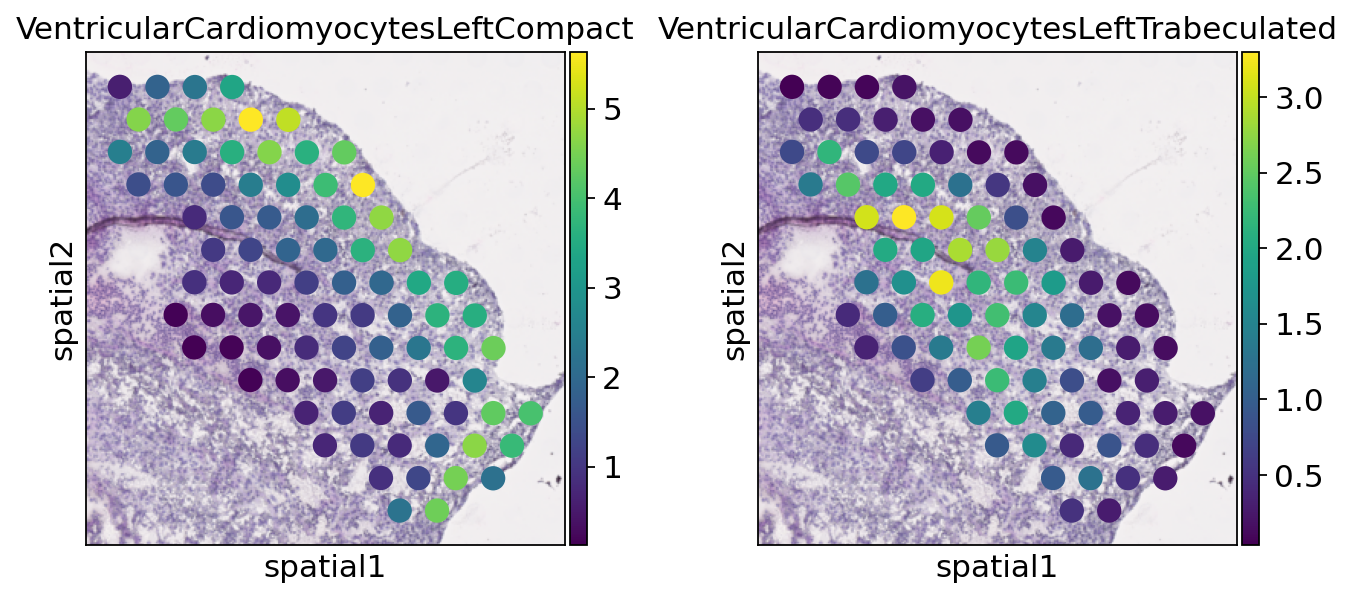

In [46]:
slide_id = 'HCAHeartST11605168'
slide = select_multislide(adata_oct_healthy, [slide_id])
cell2loc_out = slide.obsm['q05_cell_abundance_w_sf'].copy()
cell2loc_out.columns = [x.replace('q05cell_abundance_w_sf_','') for x in cell2loc_out.columns]
slide.obs[cell2loc_out.columns] = cell2loc_out.copy()
sc.pl.spatial(slide,color=['VentricularCardiomyocytesLeftCompact','VentricularCardiomyocytesLeftTrabeculated'],show=False)

[<Axes: title={'center': 'VentricularCardiomyocytesLeftCompact'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'VentricularCardiomyocytesLeftTrabeculated'}, xlabel='spatial1', ylabel='spatial2'>]

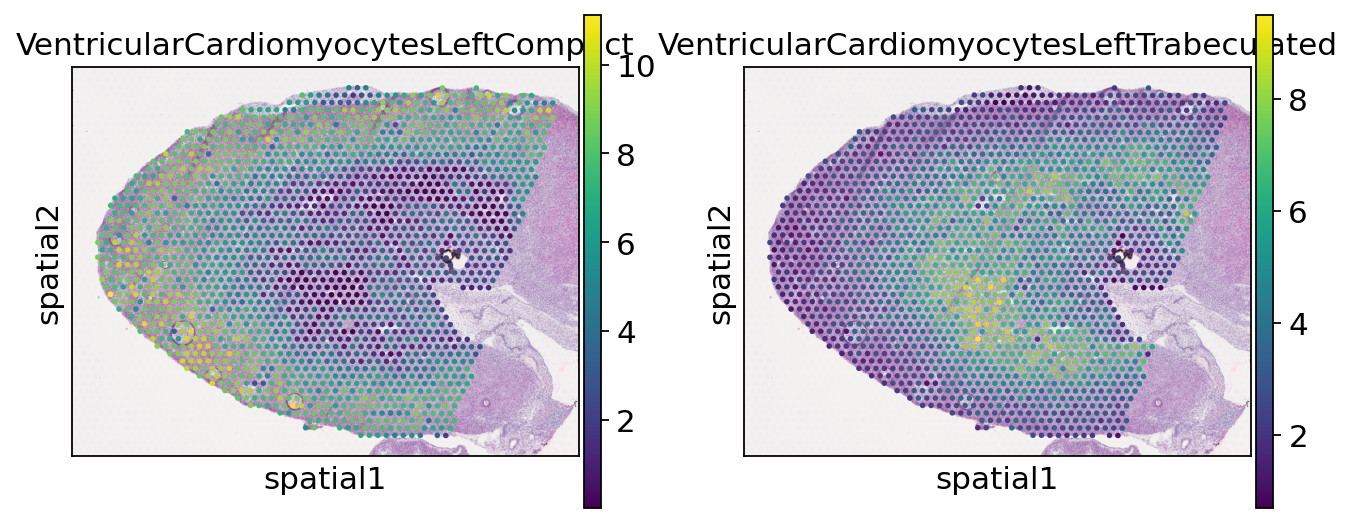

In [44]:
slide_id = 'HCAHeartST11605165'
slide = select_multislide(adata_oct_healthy, [slide_id])
cell2loc_out = slide.obsm['q05_cell_abundance_w_sf'].copy()
cell2loc_out.columns = [x.replace('q05cell_abundance_w_sf_','') for x in cell2loc_out.columns]
slide.obs[cell2loc_out.columns] = cell2loc_out.copy()
sc.pl.spatial(slide,color=['VentricularCardiomyocytesLeftCompact','VentricularCardiomyocytesLeftTrabeculated'],show=False)

[<Axes: title={'center': 'VentricularCardiomyocytesLeftCompact'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'VentricularCardiomyocytesLeftTrabeculated'}, xlabel='spatial1', ylabel='spatial2'>]

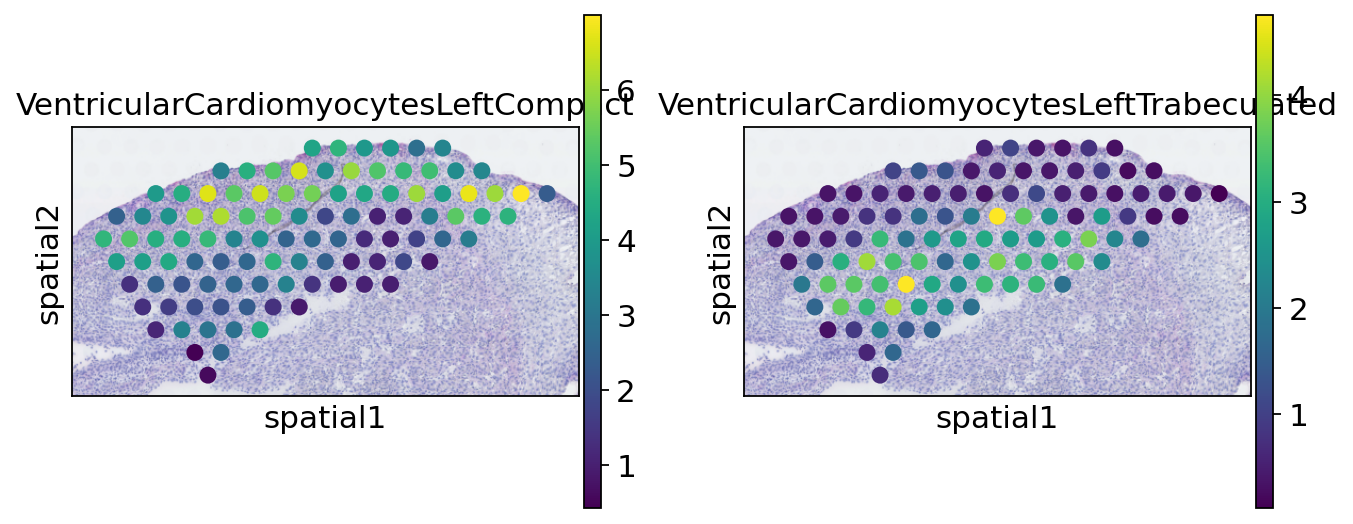

In [43]:
slide_id = 'HCAHeartST10317185'
slide = select_multislide(adata_oct_healthy, [slide_id])
cell2loc_out = slide.obsm['q05_cell_abundance_w_sf'].copy()
cell2loc_out.columns = [x.replace('q05cell_abundance_w_sf_','') for x in cell2loc_out.columns]
slide.obs[cell2loc_out.columns] = cell2loc_out.copy()
sc.pl.spatial(slide,color=['VentricularCardiomyocytesLeftCompact','VentricularCardiomyocytesLeftTrabeculated'],show=False)

[<Axes: title={'center': 'VentricularCardiomyocytesLeftCompact'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'VentricularCardiomyocytesLeftTrabeculated'}, xlabel='spatial1', ylabel='spatial2'>]

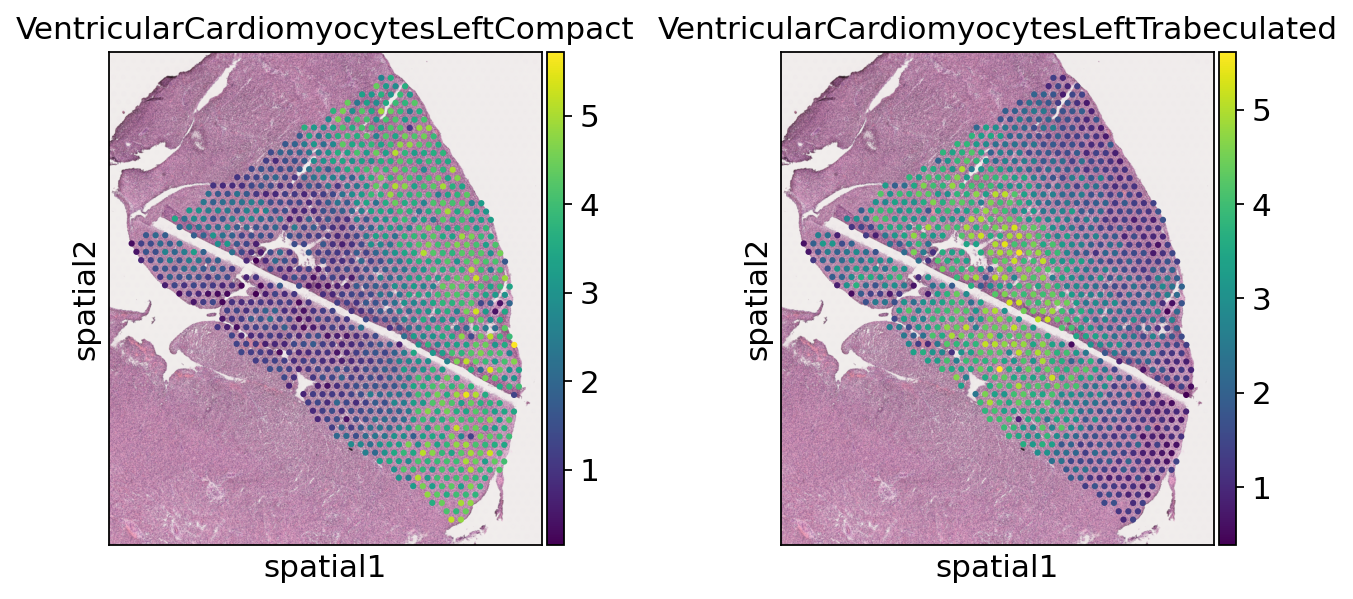

In [42]:
slide_id = 'HCAHeartST13162330'
slide = select_multislide(adata_oct_healthy_LV, [slide_id])
cell2loc_out = slide.obsm['q05_cell_abundance_w_sf'].copy()
cell2loc_out.columns = [x.replace('q05cell_abundance_w_sf_','') for x in cell2loc_out.columns]
slide.obs[cell2loc_out.columns] = cell2loc_out.copy()
sc.pl.spatial(slide,color=['VentricularCardiomyocytesLeftCompact','VentricularCardiomyocytesLeftTrabeculated'],show=False)

[<Axes: title={'center': 'VentricularCardiomyocytesLeftCompact'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'VentricularCardiomyocytesLeftTrabeculated'}, xlabel='spatial1', ylabel='spatial2'>]

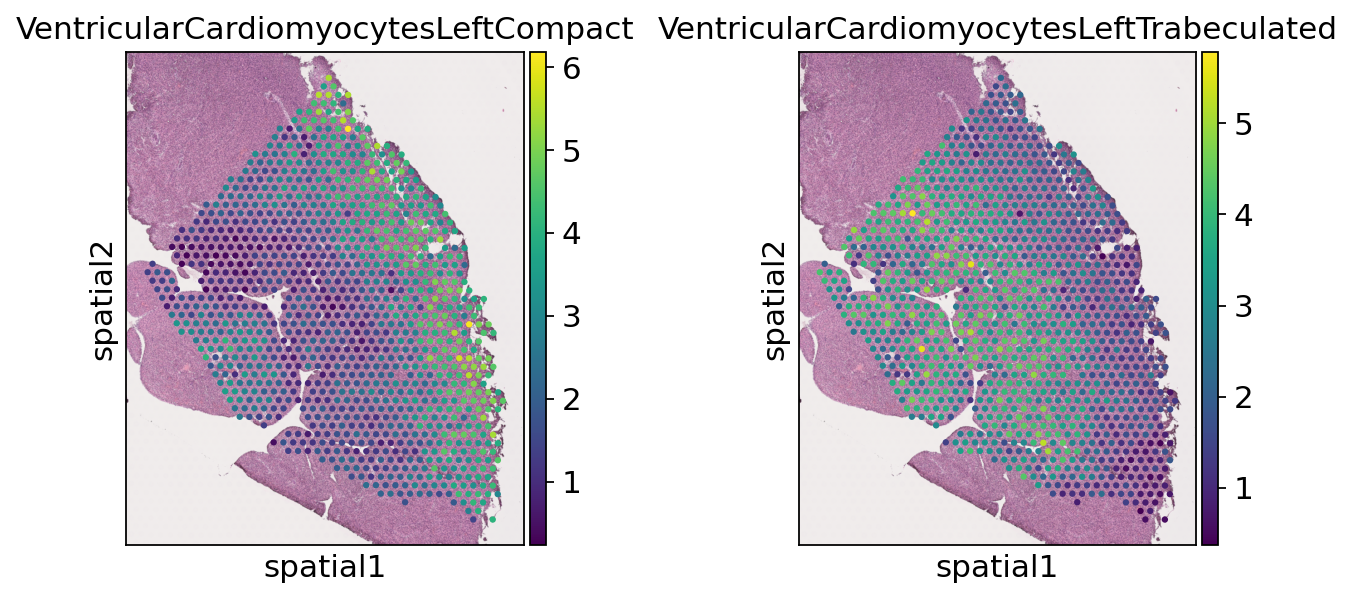

In [47]:
slide_id = 'HCAHeartST13162331'
slide = select_multislide(adata_oct_healthy_LV, [slide_id])
cell2loc_out = slide.obsm['q05_cell_abundance_w_sf'].copy()
cell2loc_out.columns = [x.replace('q05cell_abundance_w_sf_','') for x in cell2loc_out.columns]
slide.obs[cell2loc_out.columns] = cell2loc_out.copy()
sc.pl.spatial(slide,color=['VentricularCardiomyocytesLeftCompact','VentricularCardiomyocytesLeftTrabeculated'],show=False)

[<Axes: title={'center': 'VentricularCardiomyocytesLeftCompact'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'VentricularCardiomyocytesLeftTrabeculated'}, xlabel='spatial1', ylabel='spatial2'>]

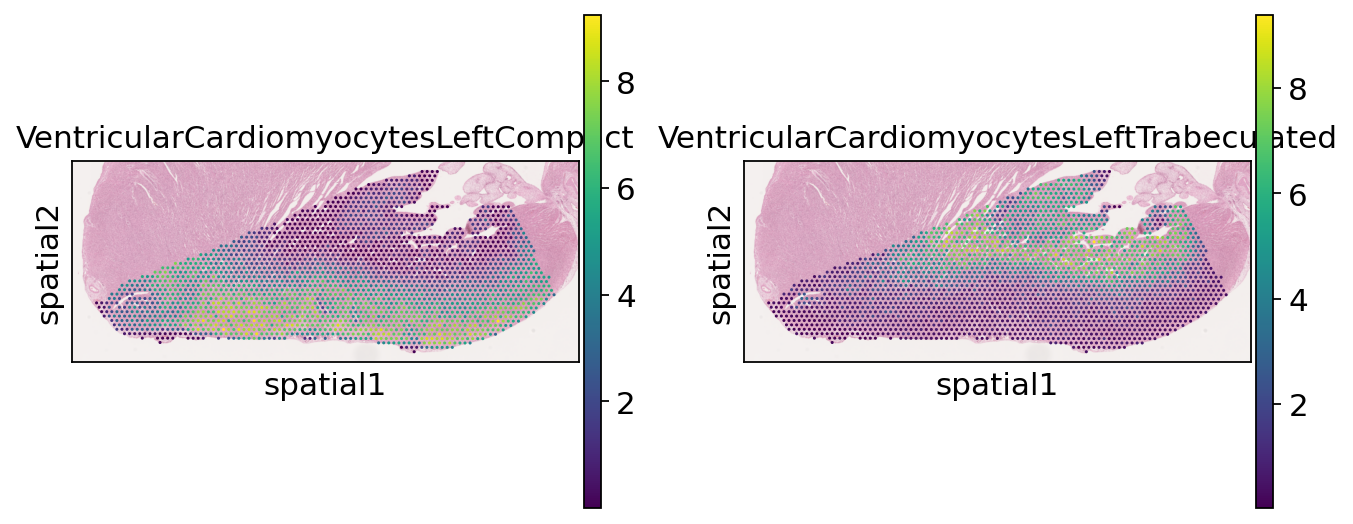

In [30]:
slide_id = 'BHF_F_Hea13295831'
slide = select_multislide(adata_ffpe, [slide_id])
cell2loc_out = slide.obsm['q05_cell_abundance_w_sf'].copy()
cell2loc_out.columns = [x.replace('q05cell_abundance_w_sf_','') for x in cell2loc_out.columns]
slide.obs[cell2loc_out.columns] = cell2loc_out.copy()
sc.pl.spatial(slide,color=['VentricularCardiomyocytesLeftCompact','VentricularCardiomyocytesLeftTrabeculated'],show=False)

[<Axes: title={'center': 'VentricularCardiomyocytesLeftCompact'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'VentricularCardiomyocytesLeftTrabeculated'}, xlabel='spatial1', ylabel='spatial2'>]

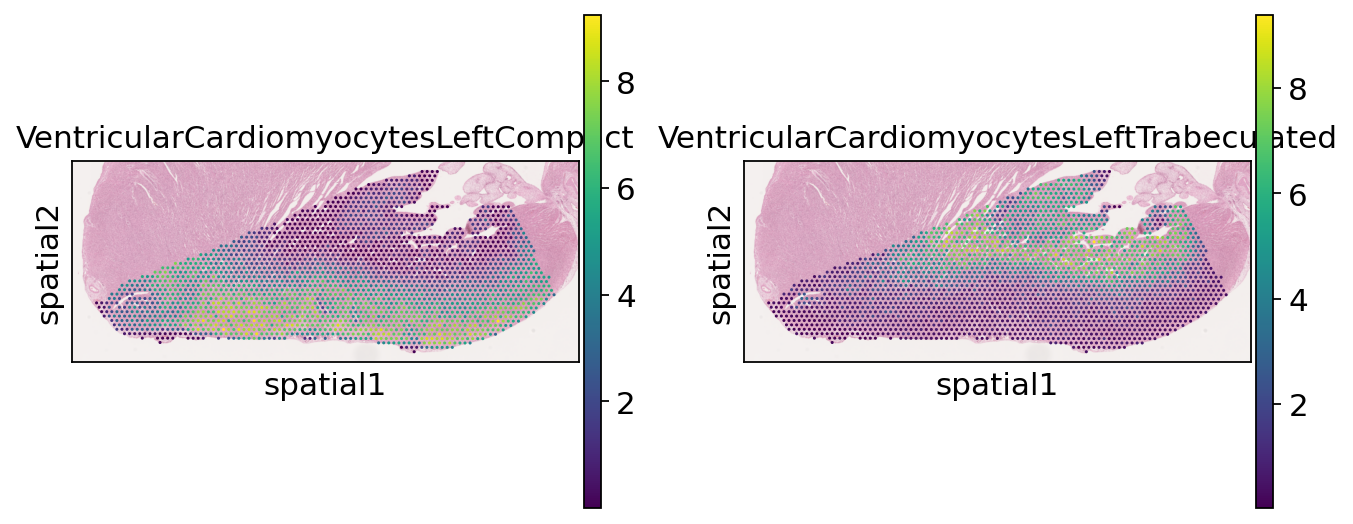

In [26]:
cell2loc_out.columns

Index(['VentricularCardiomyocytesLeftCompact',
       'VentricularCardiomyocytesLeftTrabeculated',
       'VentricularConductionSystemProximal',
       'VentricularConductionSystemDistal',
       'CoronaryVesselAdventitialFibroblasts',
       'MyocardialInterstitialFibroblasts', 'SubEpicardialFibroblasts',
       'Myofibroblasts', 'LymphNodeFibroblasticReticularCells',
       'CoronarySmoothMuscleCells', 'CoronaryPericytes',
       'CoronaryArterialEndothelialCells', 'CoronaryVenousEndothelialCells',
       'CoronaryCapillaryEndothelialCells', 'EndocardialCells',
       'LymphaticEndothelialCells', 'MesothelialEpicardialCells',
       'EpicardiumDerivedCells', 'NeuronPrecursors', 'ChromaffinCells',
       'SympatheticNeurons', 'ParasympatheticNeurons', 'SchwannCellPrecursors',
       'SchwannCells', 'MonocytesMPOpos', 'Monocytes', 'MonocyteDerivedCells',
       'MacrophagesCX3CR1pos', 'MacrophagesTIMD4pos', 'MacrophagesLYVE1pos',
       'MacrophagesATF3pos', 'DendriticCellsType1', 'Den